In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Oberösterreich",
    "Salzburg",
    "Steiermark"
]
region_dirs = ["/Users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(4, 6 + 1))]
region_dirs

['/Users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/Users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/Users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark']

## Measuring point data with regions

In [3]:
def get_num_from_str(string):
    matches = re.findall(r"\d+\.\d+", string)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_mp_attrs(region, region_dir, mp_num):

    mp_base_data_path = path.join(region_dir, "Stammdaten", "Stammdaten-{0}.txt".format(mp_num))
    
    land_height = np.nan
    mp_height = np.nan
    bottom_line = np.nan
    t_measuring_depth = np.nan
    
    with open(mp_base_data_path, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if "Geländehöhe" in line:
                land_height = get_num_from_str(line)
                
            elif "Messpunkthöhe" in line:
                mp_height = get_num_from_str(line)
                
            elif "Sohllage" in line:
                bottom_line = get_num_from_str(line)
                
            elif "T-Messtiefe u.GOK" in line:
                t_measuring_depth = get_num_from_str(line)
                
                break # since it's always listed latest in the file
    
    mp = {
        "land_height": land_height,
        "mp_height": mp_height,
        "bottom_line": bottom_line,
        "t_measuring_depth": t_measuring_depth
    }
    
    return mp


# test
region_idx = 0

# try mp with full attr
mp_num = 307843 
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

# try mp with missing attr -> np.nan in missed value
mp_num = 306910
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

mp 307843 attrs: {'land_height': '275.71', 'mp_height': '276.71', 'bottom_line': '265.81', 't_measuring_depth': '9.70'}
mp 306910 attrs: {'land_height': '257.75', 'mp_height': '258.75', 'bottom_line': '253.26', 't_measuring_depth': nan}


In [45]:
values = []

for i in range(len(regions)):
    region = regions[i]
    region_dir = region_dirs[i]
    # mps: measurment points 
    df_mps_path = path.join(region_dir, "messstellen_alle.csv")
    df_mps = pd.read_csv(df_mps_path, sep=";")
    # filter to typ == 'gw' then del typ col
    df_mps = df_mps.query("typ=='gw'")
    del df_mps["typ"]
    
    df_mps["region"] = region
    
    # for every mp in the region get attributes
    # create attrs cols and init with np.nan
    mp_attrs = ["land_height", "mp_height", "bottom_line", "t_measuring_depth"]
    for mp_attr in mp_attrs:
        df_mps[mp_attr] = np.nan
    
    # fill with values when available
    for index, row in df_mps.iterrows():
        mp_num = row["hzbnr01"]
        mp_attr_vals = get_mp_attrs(region, region_dir, mp_num = mp_num)
        for mp_attr in mp_attrs:
            df_mps.at[index, mp_attr] = float(mp_attr_vals[mp_attr])
    
    values.extend(df_mps.values.tolist())

colnames = ["x", "y", "dbmsnr", "hzbnr01", "region"] + mp_attrs
df_mps_all = pd.DataFrame(values, columns = colnames)
df_mps_all["x"] = df_mps_all["x"].str.replace(",", ".").astype(float)
df_mps_all["y"] = df_mps_all["y"].str.replace(",", ".").astype(float)

df_mps_all

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
0,375733.35,480950.72,4003250,344614,Oberösterreich,358.98,359.88,347.69,11.10
1,453010.07,473646.18,4002979,376376,Oberösterreich,310.49,310.79,296.61,NaN
2,436515.22,454178.87,4003213,344416,Oberösterreich,439.25,439.02,374.02,50.23
3,379427.33,484160.43,4002834,374074,Oberösterreich,352.39,353.09,349.51,2.78
4,506520.73,476655.34,4002230,308874,Oberösterreich,232.29,233.49,223.98,NaN
...,...,...,...,...,...,...,...,...,...
1707,597722.62,316229.92,6002179,311696,Steiermark,217.57,217.77,212.77,4.70
1708,555754.86,318845.33,6003571,356576,Steiermark,296.86,297.66,288.86,7.20
1709,596263.48,318031.55,6002809,340018,Steiermark,220.91,220.84,216.19,4.37
1710,486915.25,376334.05,6003594,356790,Steiermark,913.86,914.76,901.76,9.10


In [36]:
sal = df_mps_all[df_mps_all['region']=='Salzburg']
sal[sal['hzbnr01']==319822]

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
862,386740.88,410788.59,5002001,319822,Salzburg,468.59,468.69,462.49,NaN


In [12]:
print("Numbers of unique mp: ",df_mps_all["hzbnr01"].nunique())

Numbers of unique mp:  1712


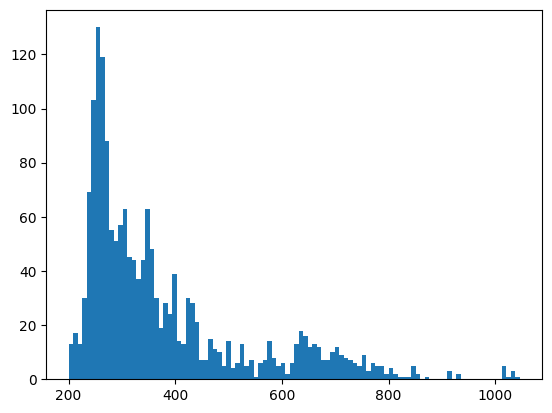

In [10]:
plt.hist(df_mps_all["land_height"], bins=100);

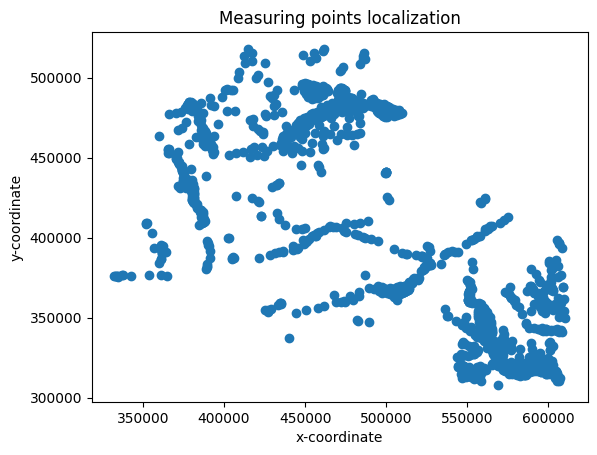

In [17]:
plt.scatter(df_mps_all["x"], df_mps_all["y"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Measuring points localization")
plt.show()

## Process region directory data

In [20]:
# know how many rows to skip in pd.read_csv
def csv_find_skiprows(filepath, lookup):
    skiprows = 0
    # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
    with open(filepath, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if lookup in line:
                skiprows = num
                # print("skiprows:", skiprows)
                break
                
    return skiprows

def process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=False):
    
    folder_dir = path.join(region_dir, folder_name)
    
    print("> Processing {} - {}..".format(region, folder_name))
    
    # clean previous processing output
    output_dir = path.join(folder_dir, "processed_data")
    
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    os.mkdir(output_dir)
    
    filenames = os.listdir(folder_dir)
    for filename in filenames:
        
        filepath = path.join(folder_dir, filename)
        
        # process only files (don't iterate over output dir)
        if not path.isfile(filepath):
            continue
        
        # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
        lookup = "Werte:"
        skiprows = csv_find_skiprows(filepath, lookup)
        
        # load and process .csv file
     
        df = pd.read_csv(filepath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape')
        
        

        # manipulate data splitting values into more possible regressors (e.g. date -> day, month, year)
        df.columns = ["date & time", val_col_name, "empty"]
        del df["empty"]
        
        # remove rows with gaps ("Lücke")
        df = df[~df[val_col_name].str.contains("Lücke")]
        
        # clean data from white spaces
        df["date & time"] = df["date & time"].str.replace("  ", "")
        
        df[["date", "time"]] = df["date & time"].str.split(" ", expand=True)
        df[["day", "month", "year"]] = df["date"].str.split(".", expand=True)
        df[["hour", "minute", "second"]] = df["time"].str.split(":", expand=True)
        # clean gw-level value and convert it to float
        df[val_col_name] = df.apply(
            lambda row: float(row[val_col_name].split(" ;")[0].replace(",", "."))
            , axis=1
        )
        # rearrange cols
        df = df[["date", "day", "month", "year", "time", "hour", "minute", "second", val_col_name]]
        
        df.to_csv(path.join(output_dir, "processed_{0}".format(filename)), index=False)
        
        # if debugging, process only one file from each sub dir 
        if debugging:
            break
        
    print("\t- Done!")

    return None

In [51]:
def create_region_mps_summary(region, region_dir, df_mps, debugging):
    
    summary_dir  = path.join(region_dir, "Summary")
    
    print("> Creating {0} Summary..".format(region))
    
    # clean previous processing output   
    try:
        shutil.rmtree(summary_dir)
    except:
        pass
    os.mkdir(summary_dir)
    
    try:
        # get processed monthly water level files as starting point
        prc_mnth_lvls_dir = path.join(region_dir, "Grundwasserstand-Monatsmittel", "processed_data")
        mnth_lvls_filenames = os.listdir(prc_mnth_lvls_dir)
        mp_num_dict = df_mps["hzbnr01"].to_dict()
        reverse_dict = {v: k for k, v in mp_num_dict.items()}
        
        
        for mnth_lvls_filename in mnth_lvls_filenames:
            
            mp_num = mnth_lvls_filename.split(".")[0].split("-")[-1]
            
            if debugging:
                mp_num = 305540 # override mp_num value to choose a mp that we have temperature data for
                print("mp_num:", mp_num)
                
            df = pd.read_csv(path.join(prc_mnth_lvls_dir, mnth_lvls_filename), sep=",")

            # add few features from measuring point dataframe: x & y coordinates and land height
            num = int(mp_num)
            df["x"] = df_mps.loc[reverse_dict[num]]["x"] if num in reverse_dict else np.nan
            df["y"] = df_mps.loc[reverse_dict[num]]["y"] if num in reverse_dict else np.nan
            df["land_height"] = df_mps.loc[reverse_dict[num]]["land_height"] if num in reverse_dict else np.nan
            
            # add extra fields, init them as NaN, then try to fill them with values
            # add fields: yr_max, yr_max_dist, yr_max_abs(dist)
            df["yr_max"] = np.nan
            df["yr_max_dist"] = np.nan
            df["yr_max_abs(dist)"] = np.nan
            
            yr_max_fpath = path.join(region_dir, "Grundwasserstand-Jahresmaxima", "processed_data", "processed_Grundwasserstand-Jahresmaxima-{0}.csv".format(mp_num))
            
            if path.exists(yr_max_fpath):
                
                df_yr_max = pd.read_csv(yr_max_fpath, sep=",")[["year", "gw-level"]]
                
                # set yr as index and create dict for O(1) search
                df_yr_max.set_index("year", inplace=True)
                dct_yr_max = df_yr_max.to_dict('index')
                
                df["yr_max"] = df.apply(
                    lambda row: dct_yr_max[row["year"]]["gw-level"] if row["year"] in dct_yr_max else np.nan
                    , axis=1)
                df["yr_max_dist"] = df.apply(
                    lambda row: round(row["gw-level"] - row["yr_max"], 2) if not row["yr_max"] == np.nan else np.nan
                    , axis=1)
                df["yr_max_abs(dist)"] = df.apply(
                    lambda row: round(np.abs(row["yr_max_dist"]), 2) if not row["yr_max_dist"] == np.nan else np.nan
                    , axis=1)
                
                # free resources
                del df_yr_max
                del dct_yr_max
                
            # add fields: yr_min, yr_min_dist, yr_min_abs(dist)
            df["yr_min"] = np.nan
            df["yr_min_dist"] = np.nan
            df["yr_min_abs(dist)"] = np.nan
            
            yr_min_fpath = path.join(region_dir, "Grundwasserstand-Jahresminima", "processed_data", "processed_Grundwasserstand-Jahresminima-{0}.csv".format(mp_num))
            
            if path.exists(yr_min_fpath):
                
                df_yr_min = pd.read_csv(yr_min_fpath, sep=",")[["year", "gw-level"]]
                
                # set yr as index and create dict for O(1) search
                df_yr_min.set_index("year", inplace=True)
                dct_yr_min = df_yr_min.to_dict('index')
                
                df["yr_min"] = df.apply(
                    lambda row: dct_yr_min[row["year"]]["gw-level"] if row["year"] in dct_yr_min else np.nan
                    , axis=1)
                df["yr_min_dist"] = df.apply(
                    lambda row: round(row["gw-level"] - row["yr_min"], 2) if not row["yr_min"] == np.nan else np.nan
                    , axis=1)
                df["yr_min_abs(dist)"] = df.apply(
                    lambda row: round(np.abs(row["yr_min_dist"]), 2) if not row["yr_min_dist"] == np.nan else np.nan
                    , axis=1)
                
                # free resources
                del df_yr_min
                del dct_yr_min
                
            # add field: temp to add temperature (Celcius) to every monthly measurement if available   
            df["temp"] = np.nan
            
            mnth_temp_fpath = path.join(region_dir, "Grundwassertemperatur-Monatsmittel", "processed_data", "processed_Grundwassertemperatur-Monatsmittel-{0}.csv".format(mp_num))
            
            # not all mps have monthly temperature data, in this case we keep it as np.nan            
            if path.exists(mnth_temp_fpath):

                # time in both ds is 00:00:00, so I only care about the date
                df_mnth_temp = pd.read_csv(mnth_temp_fpath, sep=",")[["date", "temp"]]
                df_mnth_temp.set_index("date", inplace=True)
                
                df["temp"] = df.apply(
                    lambda row: df_mnth_temp.loc[row["date"]]["temp"] if row["date"] in df_mnth_temp.index else np.nan
                    , axis=1)
                
                # free resources
                del df_mnth_temp
            
            # convert the date field to datatime object
            df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
            
            # drop ["time", "hour", "minute", "second"] cols since time is always 00:00:00
            del df["time"]
            del df["hour"]
            del df["minute"]
            del df["second"]
            del df["day"]
            del df["yr_max_dist"]
            del df["yr_min_dist"]
            
            if debugging:
                print(df)
            
            # save summary df
            df_summary_path = path.join(summary_dir, "Summary-{0}.csv".format(mp_num))
            df.to_csv(df_summary_path, sep=",", index = False)            
                
            # free resources
            del df
            
            # if debugging, create summary file for only one mp 
            if debugging:
                break
            
        
    except Exception as ex:
        print("[Error]")
        print(traceback.format_exc())
        
    print("\t- Done!")
    
    return None

def process_region_files(region, region_dir, df_mps):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_names = [
        "Grundwasserstand-Jahresmaxima",
        "Grundwasserstand-Jahresminima",
        "Grundwasserstand-Monatsmittel",
        "Grundwassertemperatur-Monatsmittel"        
    ]
    
    for folder_name in folder_names:
        if not folder_name == "Grundwassertemperatur-Monatsmittel":
            val_col_name = "gw-level"
        else:
            val_col_name = "temp"
            
        # process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=FILE_PROCESSING_DEBUGGING)
        
    # create summary files on monthly base
    SUMMARY_Creating_DEBUGGING = False # False => create summary for all mps in region
    create_region_mps_summary(region, region_dir, df_mps, debugging=SUMMARY_Creating_DEBUGGING)

In [52]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    region_idx = 1
    region = regions[region_idx]
    region_dir = region_dirs[region_idx]
    process_region_files(region, region_dir, df_mps_all)

> Creating Salzburg Summary..
	- Done!
